In [1]:
from omegaconf import OmegaConf
from torch import nn
from ldm.util import instantiate_from_config
from PIL import Image
from glob import glob
from torchvision import transforms as T
import numpy as np
from einops import rearrange
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
device = 'cuda:0'

In [3]:
images_512 = glob("/home/soon/datasets/deepfashion_inshop/img_256/**/*.jpg", recursive=True)

In [4]:
!ls models/first_stage_models/kl-f8-deepfashion

class VaeWrapper(nn.Module):
    def __init__(self, cfg, ckpt, device='cuda:0'):
        super().__init__()
        self.device = device
        conf = OmegaConf.load(cfg)
        conf['model']['params']['ckpt_path'] = ckpt

        self.vae = instantiate_from_config(conf['model']).to(device)
        self.vae.eval()
    def forward(self, x, *args):
        return self.vae(x, *args)
    

autoencoder_kl_32x32x4.yaml  deepfashion_inshop_256.ckpt  deepfashion_v1.ckpt
deepfashion_512.ckpt	     deepfashion_mm_v1.ckpt


In [12]:
cfg = './models/first_stage_models/kl-f8-deepfashion/autoencoder_kl_32x32x4.yaml'
#ckpt = './models/first_stage_models/kl-f8-deepfashion/deepfashion_inshop_256.ckpt'
#ckpt = './models/first_stage_models/kl-f8-deepfashion/deepfashion_mm_v1.ckpt'
ckpt = "./logs/2023-02-14T13-25-07_autoencoder_kl_deepfashion_256/checkpoints/last.ckpt"

vae_last = VaeWrapper(cfg, ckpt)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Restored from ./logs/2023-02-14T13-25-07_autoencoder_kl_deepfashion_256/checkpoints/last.ckpt


In [5]:
cfg = './models/first_stage_models/kl-f8-deepfashion/autoencoder_kl_32x32x4.yaml'
#ckpt = './models/first_stage_models/kl-f8-deepfashion/deepfashion_inshop_256.ckpt'
#ckpt = './models/first_stage_models/kl-f8-deepfashion/deepfashion_mm_v1.ckpt'
ckpt = "./logs/2023-02-14T13-25-07_autoencoder_kl_deepfashion_256/checkpoints/epoch=000013.ckpt"

vae = VaeWrapper(cfg, ckpt)

cfg = './models/first_stage_models/kl-f8-deepfashion/autoencoder_kl_32x32x4.yaml'
ckpt = "./logs/2023-01-10T00-42-57_autoencoder_kl_deepfashion_inshop/checkpoints/last.ckpt"

vae_small = VaeWrapper(cfg, ckpt)


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/home/soon/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/soon/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Restored from ./logs/2023-02-14T13-25-07_autoencoder_kl_deepfashion_256/checkpoints/epoch=000013.ckpt
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Restored from ./logs/2023-01-10T00-42-57_autoencoder_kl_deepfashion_inshop/checkpoints/last.ckpt


In [28]:
@torch.no_grad()
def reconstruct(model, pil_image):
    image_transform = T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x*2. -1)])
        #T.Lambda(lambda x: rearrange(x * 2. - 1., 'c h w -> h w c'))])

    pil_image = np.array(pil_image)            
    image = torch.unsqueeze(image_transform(pil_image), 0)

    dec, posterior = model(image.to(model.device), True)
    recon = rearrange(dec.squeeze(), 'c h w -> h w c').detach().cpu()
    #recon = (torch.clamp(recon, -1., 1.) + 1.)/2.
    recon = (recon + 1.)/2.
    recon = torch.clamp(recon*255, 0., 255.)
    recon = recon.numpy().astype(np.uint8)
    score = ssim(pil_image, recon, data_range=255, channel_axis=2)
    plt.figure(figsize=(7,7))
    plt.imshow(np.hstack([pil_image, recon]))
    plt.title(score)
    plt.show()

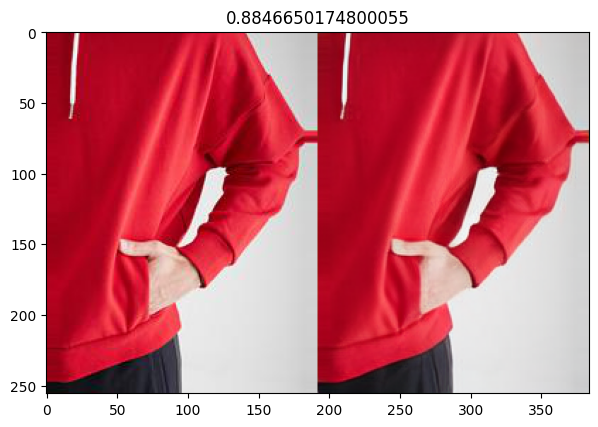

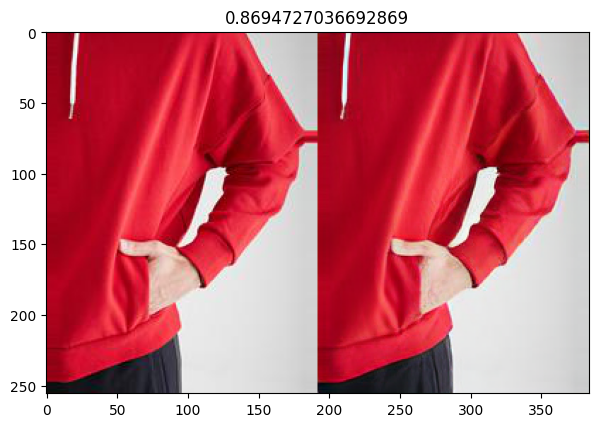

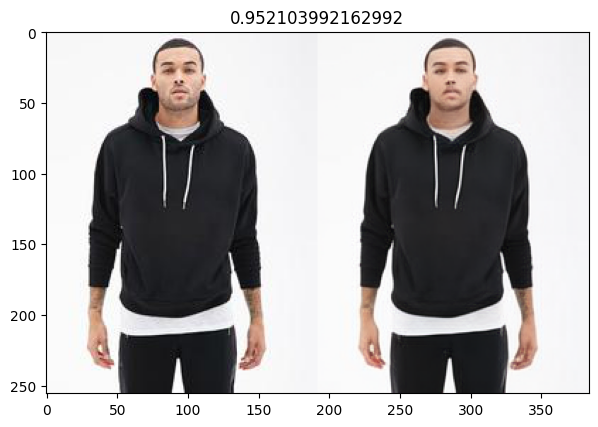

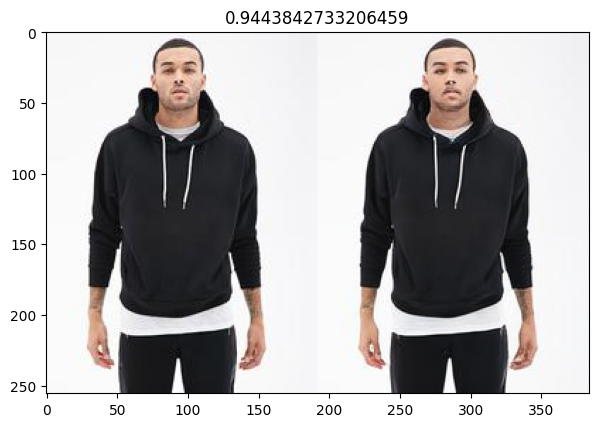

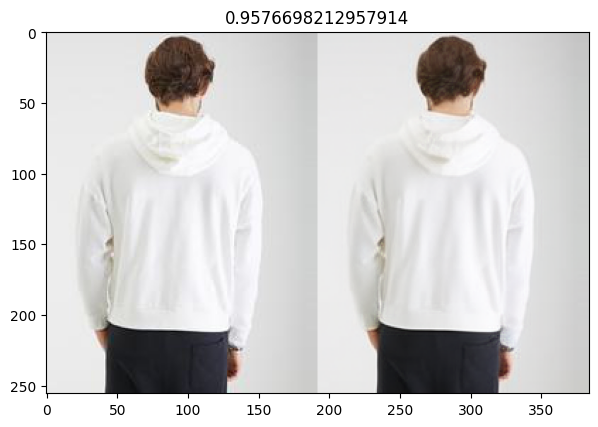

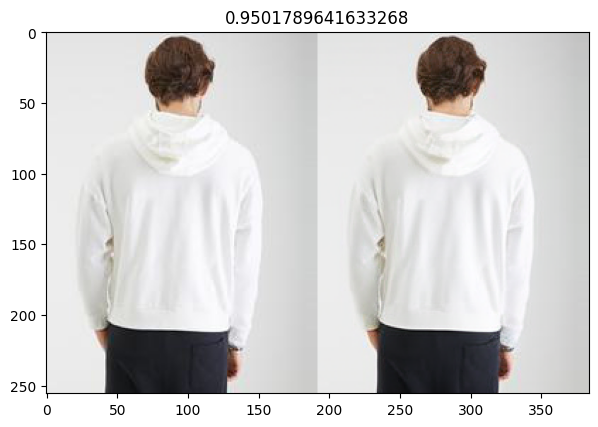

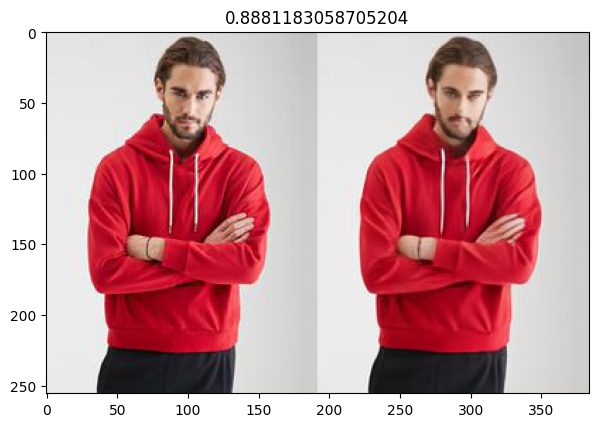

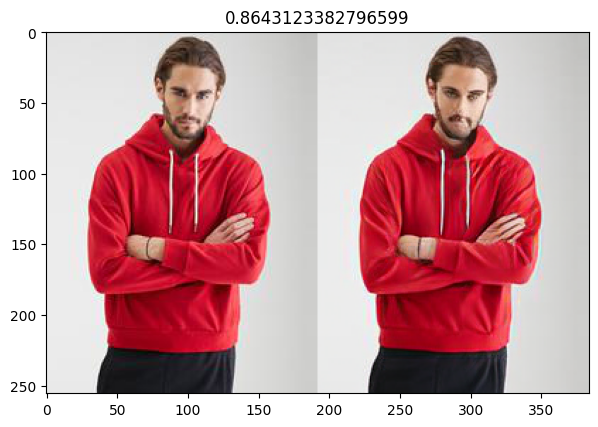

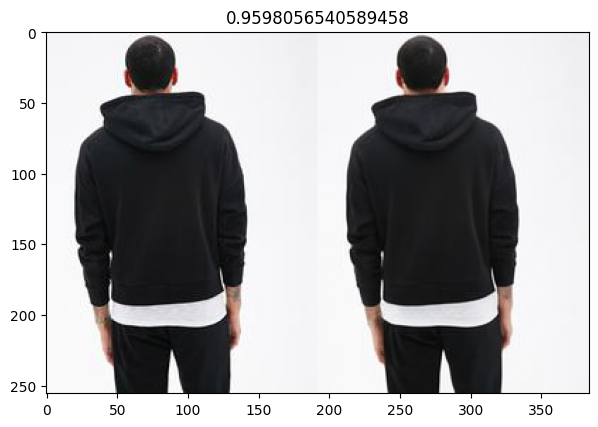

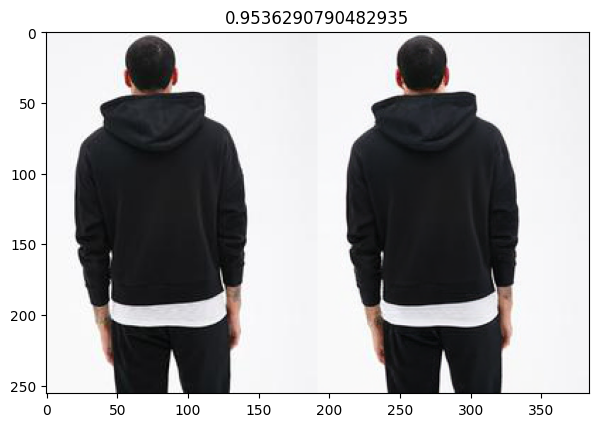

In [30]:
start=2200
for i in range(start, start+5):
    reconstruct(vae, Image.open(images_512[i]))
    reconstruct(vae_last, Image.open(images_512[i]))
    #reconstruct(vae_small, Image.open(images_512[i]))
    

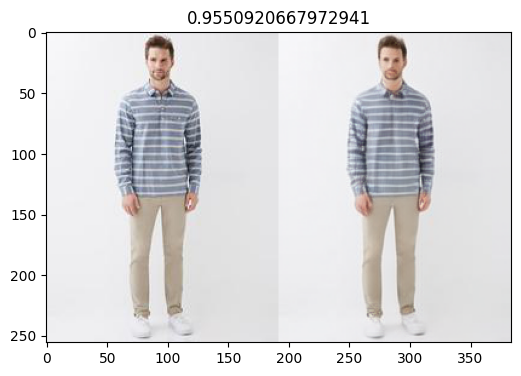

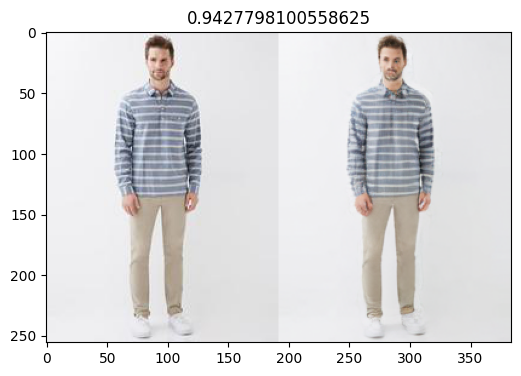

In [8]:
i = 207
reconstruct(vae, Image.open(images_512[i]))
reconstruct(vae_small, Image.open(images_512[i]))

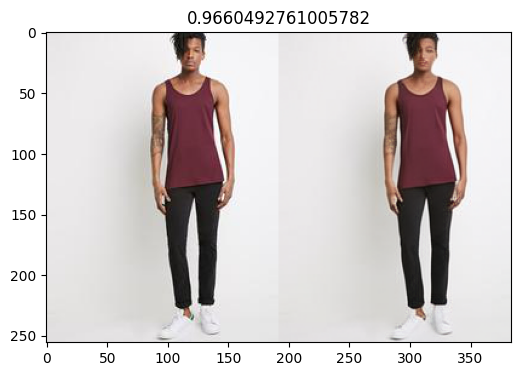

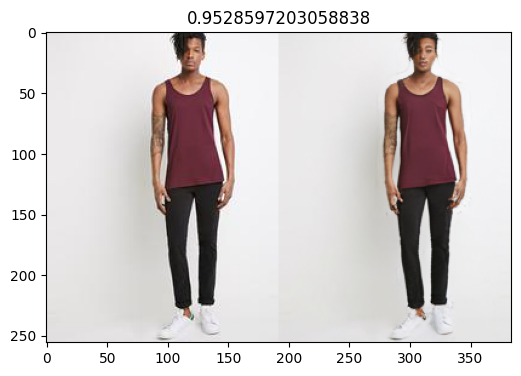

In [9]:
i = 200
reconstruct(vae, Image.open(images_512[i]))
reconstruct(vae_small, Image.open(images_512[i]))